In [28]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from PIL import Image

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Data Preprocessing

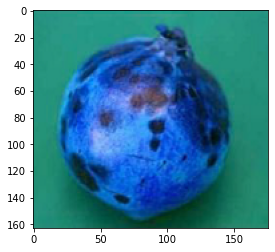

In [14]:
Train_DIR=r'C:\Users\gokha\ml_project\pomegranate_disease_detection\images\train'
Categories=['anthracnose','healthy','heartrot','sample']

for j in Categories:
    path=os.path.join(Train_DIR,j)
    for img in os.listdir(path):
        old_image=cv2.imread(os.path.join(path,img),cv2.COLOR_BGR2RGB)
        plt.imshow(old_image)
        plt.show()
        break
    break

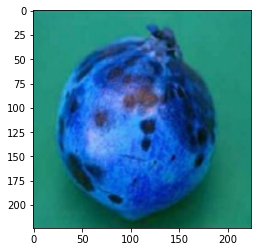

In [15]:
IMG_SIZE=224
new_image=cv2.resize(old_image,(IMG_SIZE,IMG_SIZE))
plt.imshow(new_image)
plt.show()

# Model Prepration

In [16]:
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D, Input, Lambda, Dense, Flatten
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from glob import glob

In [17]:
IMGE_SIZE = [224, 224]
inception = InceptionV3(input_shape=IMGE_SIZE + [3], weights='imagenet', include_top=False)


In [18]:
# don't train existing weights

for layer in inception.layers:
    layer.trainable = False

In [19]:
datagen=ImageDataGenerator(rescale=1./255,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                validation_split=0.2)


train_datagen=datagen.flow_from_directory(r'C:\Users\gokha\ml_project\pomegranate_disease_detection\images\train',
                                         target_size=(IMG_SIZE,IMG_SIZE),
                                         batch_size=16,
                                         class_mode='categorical',
                                         subset='training')

val_datagen=datagen.flow_from_directory(r'C:\Users\gokha\ml_project\pomegranate_disease_detection\images\train',
                                         target_size=(IMG_SIZE,IMG_SIZE),
                                         batch_size=16,
                                         class_mode='categorical',
                                         subset='validation')

Found 354 images belonging to 4 classes.
Found 87 images belonging to 4 classes.


In [20]:
  # useful for getting number of output classes
folders = glob('C:/Users/gokha/ml_project/pomegranate_disease_detection/images/train/*')
folders

['C:/Users/gokha/ml_project/pomegranate_disease_detection/images/train\\anthracnose',
 'C:/Users/gokha/ml_project/pomegranate_disease_detection/images/train\\healthy',
 'C:/Users/gokha/ml_project/pomegranate_disease_detection/images/train\\heartrot',
 'C:/Users/gokha/ml_project/pomegranate_disease_detection/images/train\\sample']

In [21]:
x = Flatten()(inception.output)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [22]:
# Compile the Model
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [23]:
checkpoint=ModelCheckpoint(r'C:\Users\gokha\ml_project\pomegranate_disease_detection\models\pomegranate_inceptionv3.h5',
                          monitor='val_loss',
                          mode='min',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor='val_loss',
                       min_delta=0,
                       patience=10,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [24]:
# fit the model
# Run the cell. It will take some time to execute
model_history = model.fit(
  train_datagen,
  validation_data=val_datagen,
  epochs=20,
  steps_per_epoch=train_datagen.samples//16,
  validation_steps=val_datagen.samples//16,
  callbacks=callbacks)

Epoch 1/20
22/22 [==============================] - 31s 1s/step - loss: 3.5477 - accuracy: 0.8787 - val_loss: 0.4896 - val_accuracy: 0.9500

Epoch 00001: val_loss improved from inf to 0.48962, saving model to C:\Users\gokha\ml_project\pomegranate_disease_detection\models\pomegranate2.h5
Epoch 2/20
22/22 [==============================] - 29s 1s/step - loss: 0.6426 - accuracy: 0.9615 - val_loss: 0.7000 - val_accuracy: 0.9500

Epoch 00002: val_loss did not improve from 0.48962
Epoch 3/20
22/22 [==============================] - 31s 1s/step - loss: 0.5041 - accuracy: 0.9586 - val_loss: 0.4330 - val_accuracy: 0.9500

Epoch 00003: val_loss improved from 0.48962 to 0.43301, saving model to C:\Users\gokha\ml_project\pomegranate_disease_detection\models\pomegranate2.h5
Epoch 4/20
22/22 [==============================] - 31s 1s/step - loss: 0.2874 - accuracy: 0.9822 - val_loss: 1.5447 - val_accuracy: 0.9375

Epoch 00004: val_loss did not improve from 0.43301
Epoch 5/20
22/22 [==================

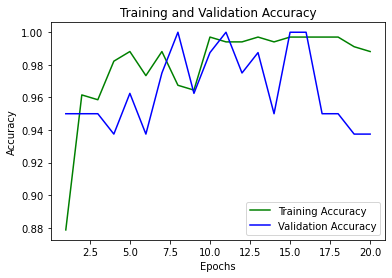

In [25]:
acc_train=model_history.history['accuracy']
acc_val=model_history.history['val_accuracy']
epochs=range(1,21)
plt.plot(epochs,acc_train,'g',label='Training Accuracy')
plt.plot(epochs,acc_val,'b',label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

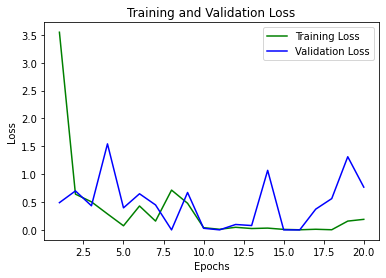

In [26]:
loss_train=model_history.history['loss']
loss_val=model_history.history['val_loss']
epochs=range(1,21)
plt.plot(epochs,loss_train,'g',label='Training Loss')
plt.plot(epochs,loss_val,'b',label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Making the Prediction on a Single Image

2


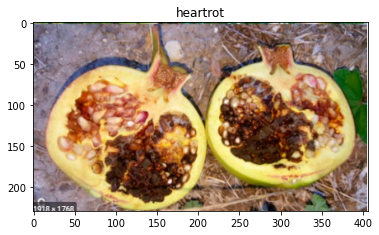

In [50]:
test_image=r'C:\Users\gokha\ml_project\pomegranate_disease_detection\images\train\heartrot\5.jpg'
image_result=Image.open(test_image)

from tensorflow.keras.preprocessing import image
test_image=image.load_img(test_image,target_size=(224,224))
test_image=image.img_to_array(test_image)
test_image=test_image/255
test_image=np.expand_dims(test_image,axis=0)
result=model.predict(test_image)
print(np.argmax(result))
Categories=['anthracnose','healthy','heartrot','sample']
image_result=plt.imshow(image_result)
plt.title(Categories[np.argmax(result)])
plt.show()